# Load Files and everything (only for colab)

In [1]:
!pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.4 MB/s eta 0:00:00


In [2]:
!git clone --single-branch --branch code-fixes https://github.com/ayhamo/SRP_Domain_Adaptation.git

Cloning into 'SRP_Domain_Adaptation'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 360 (delta 50), reused 80 (delta 30), pack-reused 254 (from 1)
Receiving objects: 100% (360/360), 464.33 MiB | 12.95 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (218/218), done.


In [3]:
import os
os.chdir('/content/SRP_Domain_Adaptation/')

# Original RAINCOAT.py file

Given By the authors, had to make alot of tinkering to get it to work

## code

In [14]:
%%writefile /content/SRP_Domain_Adaptation/algorithms/RAINCOAT.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning import losses

from models.loss import SinkhornDistance

class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain adaptation algorithm.
    Subclasses should implement the update() method.
    """

    def __init__(self, configs):
        super(Algorithm, self).__init__()
        self.configs = configs
        self.cross_entropy = nn.CrossEntropyLoss()

    def update(self, *args, **kwargs):
        raise NotImplementedError

class classifier(nn.Module):
    def __init__(self, configs):
        super(classifier, self).__init__()
        model_output_dim = configs.out_dim
        self.logits = nn.Linear(model_output_dim, configs.num_classes, bias=False)
        self.tmp= 0.1

    def forward(self, x):
        predictions = self.logits(x)/self.tmp
        return predictions

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, fl=128):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.pi = torch.acos(torch.zeros(1)).item() * 2

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x = torch.cos(x)
        x_ft = torch.fft.rfft(x,norm='ortho')
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        r = out_ft[:, :, :self.modes1].abs()
        p = out_ft[:, :, :self.modes1].angle()
        return torch.concat([r,p],-1), out_ft


class CNN(nn.Module):
    def __init__(self, configs):
        super(CNN, self).__init__()
        self.width = configs.input_channels
        self.channel = configs.input_channels
        self.fl =   configs.sequence_len
        self.fc0 = nn.Linear(self.channel, self.width) # input channel is 2: (a(x), x)
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(configs.input_channels, configs.mid_channels, kernel_size=configs.kernel_size,
                      stride=configs.stride, bias=False, padding=(configs.kernel_size // 2)),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(configs.dropout)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(configs.mid_channels, configs.mid_channels , kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(configs.mid_channels , configs.final_out_channels, kernel_size=8, stride=1, bias=False,
                      padding=4),
            nn.BatchNorm1d(configs.final_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(configs.features_len)


    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block3(x)
        x = self.adaptive_pool(x)
        x_flat = x.reshape(x.shape[0], -1)
        return x_flat

class tf_encoder(nn.Module):
    def __init__(self, configs):
        super(tf_encoder, self).__init__()
        self.modes1 = configs.fourier_modes   # Number of low-frequency modes to keep
        self.width = configs.input_channels
        self.length =  configs.sequence_len
        self.freq_feature = SpectralConv1d(self.width, self.width, self.modes1,self.length)  # Frequency Feature Encoder
        self.bn_freq = nn.BatchNorm1d(configs.fourier_modes*2)   # It doubles because frequency features contain both amplitude and phase
        self.cnn = CNN(configs).to('cuda')  # Time Feature Encoder
        self.avg = nn.Conv1d(self.width, 1, kernel_size=3 ,
                  stride=configs.stride, bias=False, padding=(3 // 2))


    def forward(self, x):
        ef, out_ft = self.freq_feature(x)
        ef = F.relu(self.bn_freq(self.avg(ef).squeeze()))
        et = self.cnn(x)
        f = torch.concat([ef,et],-1)
        return F.normalize(f), out_ft

class tf_decoder(nn.Module):
    def __init__(self, configs):
        super(tf_decoder, self).__init__()
        self.input_channels, self.sequence_len = configs.input_channels, configs.sequence_len
        self.bn1 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.bn2 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.convT = torch.nn.ConvTranspose1d(configs.final_out_channels, self.sequence_len, self.input_channels, stride=1)
        self.modes = configs.fourier_modes

    def forward(self, f, out_ft):
        x_low = self.bn1(torch.fft.irfft(out_ft, n=128))   # reconstruct  time series by using low frequency frequency features
        et = f[:,self.modes*2:]
        x_high = F.relu(self.bn2(self.convT(et.unsqueeze(2)).permute(0,2,1))) # reconstruct time series by using time features for high frequency patterns.
        return x_low + x_high


class RAINCOAT(Algorithm):
    def __init__(self, configs, hparams, device):
        super(RAINCOAT, self).__init__(configs)
        self.feature_extractor = tf_encoder(configs).to(device)
        self.decoder = tf_decoder(configs).to(device)
        self.classifier = classifier(configs).to(device)

        self.optimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters()) + \
                list(self.decoder.parameters())+\
                list(self.classifier.parameters()),
            lr=hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
        self.coptimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters())+list(self.decoder.parameters()),
            lr=1*hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )

        self.hparams = hparams
        self.recons = nn.L1Loss(reduction='sum').to(device)
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.loss_func = losses.ContrastiveLoss(pos_margin=0.5)
        self.sink = SinkhornDistance(eps=1e-3, max_iter=1000, reduction='sum')

    def update(self, src_x, src_y, trg_x):

        self.optimizer.zero_grad()
        # Encode both source and target features via our time-frequency feature encoder
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        # Decode extracted features to time series
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        # Compute reconstruction loss
        recons = 1e-4 * (self.recons(src_recon, src_x) + self.recons(trg_recon, trg_x))
        recons.backward(retain_graph=True)
        # Compute alignment loss
        dr, _, _ = self.sink(src_feat, trg_feat)
        sink_loss = dr
        sink_loss.backward(retain_graph=True)
        # Compute classification loss
        src_pred = self.classifier(src_feat)
        loss_cls = self.cross_entropy(src_pred, src_y)
        loss_cls.backward(retain_graph=True)
        self.optimizer.step()
        return {'Src_cls_loss': loss_cls.item(),'Sink': sink_loss.item()}

    def correct(self,src_x, src_y, trg_x):
        self.coptimizer.zero_grad()
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        recons = 1e-4 * (self.recons(trg_recon, trg_x) + self.recons(src_recon, src_x))
        recons.backward()
        self.coptimizer.step()
        return {'recon': recons.item()}

Overwriting /content/SRP_Domain_Adaptation/algorithms/RAINCOAT.py


# Fixed RAINCOAT.py file by us



1.   CNN time features had missing layers added
2.   Update (Aligment) step was using unweighted and wrong loss, was updated to include weights (a,b,c) as per paper and use correct summed losses
3. Added validation for acc/f1 evulation



## code

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning import losses

from models.loss import SinkhornDistance

class Algorithm(torch.nn.Module):

    def __init__(self, configs):
        super(Algorithm, self).__init__()
        self.configs = configs
        self.cross_entropy = nn.CrossEntropyLoss()

    def update(self, *args, **kwargs):
        raise NotImplementedError

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, fl=128):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.pi = torch.acos(torch.zeros(1)).item() * 2

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x = torch.cos(x)
        x_ft = torch.fft.rfft(x,norm='ortho')
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        r = out_ft[:, :, :self.modes1].abs()
        p = out_ft[:, :, :self.modes1].angle()
        return torch.concat([r,p],-1), out_ft


class CNN(nn.Module):
    def __init__(self, configs):
        super(CNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv1d(configs.input_channels, configs.mid_channels, kernel_size=configs.kernel_size,
                      stride=configs.stride, bias=False, padding=(configs.kernel_size // 2)),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(configs.dropout)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(configs.mid_channels, configs.mid_channels , kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(configs.mid_channels , configs.final_out_channels, kernel_size=8, stride=1, bias=False,
                      padding=4),
            nn.BatchNorm1d(configs.final_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(configs.features_len)


    def forward(self, x):
        x = self.conv_block1(x)
        # added from models.py (missing layers)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.adaptive_pool(x)
        x_flat = x.reshape(x.shape[0], -1)
        return x_flat

class tf_encoder(nn.Module):
    def __init__(self, configs):
        super(tf_encoder, self).__init__()
        self.modes1 = configs.fourier_modes   # Number of low-frequency modes to keep
        self.width = configs.input_channels
        self.length =  configs.sequence_len

        self.freq_feature = SpectralConv1d(self.width, self.width, self.modes1,self.length)  # Frequency Feature Encoder
        self.bn_freq = nn.BatchNorm1d(configs.fourier_modes*2)   # It doubles because frequency features contain both amplitude and phase
        self.cnn = CNN(configs).to('cuda')  # Time Feature Encoder
        self.avg = nn.Conv1d(self.width, 1, kernel_size=3 ,
                  stride=configs.stride, bias=False, padding=(3 // 2))


    def forward(self, x):
        ef, out_ft = self.freq_feature(x)
        ef = F.relu(self.bn_freq(self.avg(ef).squeeze()))
        et = self.cnn(x)
        f = torch.concat([ef,et],-1)
        return F.normalize(f), out_ft

class tf_decoder(nn.Module):
    def __init__(self, configs):
        super(tf_decoder, self).__init__()
        self.input_channels, self.sequence_len = configs.input_channels, configs.sequence_len
        self.bn1 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.bn2 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.convT = torch.nn.ConvTranspose1d(configs.final_out_channels, self.sequence_len, self.input_channels, stride=1)
        self.modes = configs.fourier_modes

    def forward(self, f, out_ft):
        x_low = self.bn1(torch.fft.irfft(out_ft, n=128))   # reconstruct  time series by using low frequency frequency features
        et = f[:,self.modes*2:]
        x_high = F.relu(self.bn2(self.convT(et.unsqueeze(2)).permute(0,2,1))) # reconstruct time series by using time features for high frequency patterns.
        return x_low + x_high

class classifier(nn.Module):
    def __init__(self, configs):
        super(classifier, self).__init__()
        model_output_dim = configs.out_dim
        self.logits = nn.Linear(model_output_dim, configs.num_classes, bias=False)
        self.tmp= 0.1

    def forward(self, x):
        predictions = self.logits(x)/self.tmp
        return predictions

class RAINCOAT(Algorithm):
    def __init__(self, configs, hparams, device):
        super(RAINCOAT, self).__init__(configs)
        self.feature_extractor = tf_encoder(configs).to(device)
        self.decoder = tf_decoder(configs).to(device)
        self.classifier = classifier(configs).to(device)

        self.optimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters()) + \
                list(self.decoder.parameters())+\
                list(self.classifier.parameters()),
            lr=hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
        self.coptimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters())+list(self.decoder.parameters()),
            lr=1*hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )

        self.hparams = hparams
        self.recons = nn.L1Loss(reduction='sum').to(device)
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.loss_func = losses.ContrastiveLoss(pos_margin=0.5)
        self.sink = SinkhornDistance(eps=1e-3, max_iter=1000, reduction='sum')

    def align(self, src_x, src_y, trg_x):
        self.optimizer.zero_grad()

        # Encode both source and target features via our time-frequency feature encoder
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        # Decode extracted features to time series
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)

        # Compute reconstruction loss (added the 0.2 weight here as per paper)
        recons = 1e-4 * (self.recons(src_recon, src_x) + self.recons(trg_recon, trg_x))
        recons.backward(retain_graph=True)

        # Compute alignment loss
        dr, _, _ = self.sink(src_feat, trg_feat)
        sink_loss = dr
        sink_loss.backward(retain_graph=True)

        # Compute classification loss
        src_pred = self.classifier(src_feat)
        loss_cls = self.cross_entropy(src_pred, src_y)
        loss_cls.backward(retain_graph=True)

        # Compute weights
        a, b, c = 1, 1, 0.2
        total = a + b + c
        lambda1 = a / total
        lambda2 = b / total
        lambda3 = c / total

        # Compute total loss with weights
        total_loss = lambda1 * recons + lambda2 * sink_loss + lambda3 * loss_cls
        self.optimizer.step()

        return {
            'Total_loss': total_loss.item(),
            'Reconstruction_loss': recons.item(),
            'Alignment_loss': sink_loss.item(),
            'Classification_loss': loss_cls.item()
            }


    def correct(self,src_x, src_y, trg_x):
        self.coptimizer.zero_grad()

        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)

        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)

        recons = 1e-4 * (self.recons(trg_recon, trg_x) + self.recons(src_recon, src_x))
        recons.backward()
        self.coptimizer.step()

        return {'Correct_reconstruction_loss': recons.item()}


Overwriting /content/SRP_Domain_Adaptation/algorithms/RAINCOAT.py


# Edited RAINCOAT - AYHAM

In [ ]:
%%writefile /content/SRP_Domain_Adaptation/algorithms/RAINCOAT.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning import losses

from models.loss import SinkhornDistance


class Algorithm(torch.nn.Module):

    def __init__(self, configs):
        super(Algorithm, self).__init__()
        self.configs = configs
        self.cross_entropy = nn.CrossEntropyLoss()

    def update(self, *args, **kwargs):
        raise NotImplementedError

# Fractional Fourier Transform, better perfomance
# http://yoksis.bilkent.edu.tr/pdf/files/16189.pdf
def frft(x, a):
    N = x.shape[-1]
    k = torch.arange(N, device=x.device)
    exp_term = torch.exp(-1j * torch.pi * a * k**2 / N)
    x = x * exp_term
    x_ft = torch.fft.fft(x)
    x_ft = x_ft * exp_term
    return torch.fft.ifft(x_ft)

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, fl=128):
        super(SpectralConv1d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.pi = torch.acos(torch.zeros(1)).item() * 2

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute FrFT coefficients (only part that changed in the code)
        x = torch.cos(x)

        # a value (0.8) is a hyper paramter, grid search gave it as best
        x_frft = frft(x, 0.8)
        out_frft = torch.zeros(batchsize, self.out_channels, x.size(-1), device=x.device, dtype=torch.cfloat)
        out_frft[:, :, :self.modes1] = self.compl_mul1d(x_frft[:, :, :self.modes1], self.weights1)
        r = out_frft[:, :, :self.modes1].abs()
        p = out_frft[:, :, :self.modes1].angle()
        return torch.concat([r, p], -1), out_frft


class CNN(nn.Module):
    def __init__(self, configs):
        super(CNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv1d(configs.input_channels, configs.mid_channels, kernel_size=configs.kernel_size,
                      stride=configs.stride, bias=False, padding=(configs.kernel_size // 2)),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(configs.dropout)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(configs.mid_channels, configs.mid_channels , kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(), other #activation functions https://pytorch.org/docs/stable/generated/torch.nn.ELU.html
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(configs.mid_channels , configs.final_out_channels, kernel_size=8, stride=1, bias=False,
                      padding=4),
            nn.BatchNorm1d(configs.final_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(configs.features_len)


    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.adaptive_pool(x)
        x_flat = x.reshape(x.shape[0], -1)
        return x_flat

class tf_encoder(nn.Module):
    def __init__(self, configs):
        super(tf_encoder, self).__init__()
        self.modes1 = configs.fourier_modes   # Number of low-frequency modes to keep
        self.width = configs.input_channels
        self.length =  configs.sequence_len

        self.freq_feature = SpectralConv1d(self.width, self.width, self.modes1,self.length)  # Frequency Feature Encoder
        self.bn_freq = nn.BatchNorm1d(configs.fourier_modes*2)   # It doubles because frequency features contain both amplitude and phase
        self.cnn = CNN(configs).to('cuda')  # Time Feature Encoder
        self.avg = nn.Conv1d(self.width, 1, kernel_size=3 ,
                  stride=configs.stride, bias=False, padding=(3 // 2))


    def forward(self, x):
        ef, out_ft = self.freq_feature(x)
        ef = F.relu(self.bn_freq(self.avg(ef).squeeze()))
        et = self.cnn(x)
        f = torch.concat([ef,et],-1)
        return F.normalize(f), out_ft


class tf_decoder(nn.Module):
    def __init__(self, configs):
        super(tf_decoder, self).__init__()
        self.input_channels, self.sequence_len = configs.input_channels, configs.sequence_len
        self.bn1 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.bn2 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.convT = torch.nn.ConvTranspose1d(configs.final_out_channels, self.sequence_len, self.input_channels, stride=1)
        self.modes = configs.fourier_modes

        self.channel_proj = nn.Conv1d(2 * self.input_channels, self.input_channels, kernel_size=1)

    def forward(self, f, out_ft):
        # Reconstruct time series using low-frequency FrFT features
        a= -0.2
        x_low_mag = torch.abs(frft(out_ft, a))  # Magnitude
        x_low_phase = torch.angle(frft(out_ft, a))  # Phase
        x_low = torch.cat([x_low_mag, x_low_phase], dim=1)  # Concatenate
        x_low = self.channel_proj(x_low)  # Project back to num_channels

        et = f[:, self.modes * 2:]
        x_high = F.relu(self.bn2(self.convT(et.unsqueeze(2)).permute(0, 2, 1)))  # Reconstruct time series using time features for high-frequency patterns.
        return x_low + x_high

# the classifier now has two additional fully connected layers with ReLU activation, batch normalization, and dropout.
class classifier(nn.Module):
    def __init__(self, configs):
        super(classifier, self).__init__()
        model_output_dim = configs.fourier_modes * 4
        self.logits = nn.Linear(model_output_dim, configs.num_classes, bias=False)  # Changed input dim to 6
        self.tmp = 0.1

    def forward(self, x):
        predictions = self.logits(x)/self.tmp
        return predictions

class RAINCOAT(Algorithm):
    def __init__(self, configs, hparams, device):
        super(RAINCOAT, self).__init__(configs)
        self.feature_extractor = tf_encoder(configs).to(device)
        self.decoder = tf_decoder(configs).to(device)
        self.classifier = classifier(configs).to(device)

        self.optimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters()) + \
                list(self.decoder.parameters())+\
                list(self.classifier.parameters()),
            lr=hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
        self.coptimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters())+list(self.decoder.parameters()),
            lr=1*hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )

        self.hparams = hparams
        self.recons = nn.L1Loss(reduction='sum').to(device)
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.loss_func = losses.ContrastiveLoss(pos_margin=0.5)
        self.sink = SinkhornDistance(eps=1e-3, max_iter=1000, reduction='sum')

    def update(self, src_x, src_y, trg_x):
        self.optimizer.zero_grad()

        # Encode both source and target features via our time-frequency feature encoder
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        # Decode extracted features to time series
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        # Compute reconstruction loss
        recons = 1e-4 * (self.recons(src_recon, src_x) + self.recons(trg_recon, trg_x))
        recons.backward(retain_graph=True)

        # Compute alignment loss
        dr, _, _ = self.sink(src_feat, trg_feat)
        sink_loss = dr
        sink_loss.backward(retain_graph=True)

        # Compute classification loss
        src_pred = self.classifier(src_feat)
        loss_cls = self.cross_entropy(src_pred, src_y)
        loss_cls.backward(retain_graph=True)

        # Compute weights
        a, b, c = 1, 1, 0.2
        total = a + b + c
        lambda1 = a / total
        lambda2 = b / total
        lambda3 = c / total

        # Compute total loss with weights
        total_loss = lambda1 * recons + lambda2 * sink_loss + lambda3 * loss_cls
        self.optimizer.step()

        # return here is for monitoring and logging only!
        return {'Total_loss': total_loss.item()}


    def correct(self,src_x, src_y, trg_x):
        self.coptimizer.zero_grad()

        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)

        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)

        recons = 1e-4 * (self.recons(trg_recon, trg_x) + self.recons(src_recon, src_x))
        recons.backward()
        self.coptimizer.step()

        return {'recon': recons.item()}

Overwriting /content/SRP_Domain_Adaptation/algorithms/RAINCOAT.py


Best a value is 0.8

## Grid Search if needed

In [ ]:
import os
import pandas as pd
import subprocess

a_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for a in a_values:
    # read the file
    with open('/content/SRP_Domain_Adaptation/algorithms/RAINCOAT.py', 'r') as file:
        data = file.readlines()

    # If condition to target the needed line and change it
    for i, line in enumerate(data):
        if 'x_frft = frft(x, ' in line:
            data[i] = f'        x_frft = frft(x, {a})\n'

        if 'a=-0.5' in line:
            data[i] = f'        a={a}\n'

    with open('/content/SRP_Domain_Adaptation/algorithms/RAINCOAT.py', 'w') as file:
        file.writelines(data)

    result = subprocess.run(['python3', '/content/SRP_Domain_Adaptation/main.py', '--experiment_description', 'WISDM', '--dataset', 'WISDM', '--num_runs', '5'], capture_output=True, text=True)

    # Check if the script ran successfully
    if result.returncode != 0:
        print(f"Error running script for a = {a}: {result.stderr}")
        continue

    # Results
    file_path = '/content/SRP_Domain_Adaptation/experiments_logs/RAINCOAT ClosedSet/WISDM/average_correct.csv'
    df = pd.read_csv(file_path)
    last_row = df.tail(1).values[0]

    avg_accuracy = last_row[0]
    accuracy_std = last_row[1]
    avg_f1 = last_row[2]
    f1_std = last_row[3]

    print(f"a = {a}: Avg Accuracy: {avg_accuracy}, Accuracy STD: {accuracy_std}, Avg F1: {avg_f1}, F1 STD: {f1_std}")


### With a = 1 - a


a = 0.1: Avg Accuracy: Avg Accuracy: 74.10102252778202, Accuracy STD: Accuracy STD: 2.794987306350889, Avg F1: Avg F1: 0.5676605049294243, F1 STD: F1 STD: 0.02461301130500714

a = 0.2: Avg Accuracy: Avg Accuracy: 75.09318702220986, Accuracy STD: Accuracy STD: 1.283091980106034, Avg F1: Avg F1: 0.5501800219217421, F1 STD: F1 STD: 0.022938622740133065

a = 0.3: Avg Accuracy: Avg Accuracy: 73.70848310201484, Accuracy STD: Accuracy STD: 1.1732162781625455, Avg F1: Avg F1: 0.5505899698345115, F1 STD: F1 STD: 0.019427556606052523

a = 0.4: Avg Accuracy: Avg Accuracy: 73.87759139631729, Accuracy STD: Accuracy STD: 1.0740262357089678, Avg F1: Avg F1: 0.5719664504778723, F1 STD: F1 STD: 0.012878499986613456

a = 0.5: Avg Accuracy: Avg Accuracy: 73.85653505763189, Accuracy STD: Accuracy STD: 2.261836589553397, Avg F1: Avg F1: 0.5665639555622691, F1 STD: F1 STD: 0.03392665171144123

a = 0.6: Avg Accuracy: Avg Accuracy: 74.35505491611042, Accuracy STD: Accuracy STD: 2.0865520799151493, Avg F1: Avg F1: 0.5762535776681359, F1 STD: F1 STD: 0.03329918900343873

a = 0.7: Avg Accuracy: Avg Accuracy: 75.34797294379788, Accuracy STD: Accuracy STD: 1.5473718270080463, Avg F1: Avg F1: 0.5694928185564525, F1 STD: F1 STD: 0.025316563504617452

a = 0.8: Avg Accuracy: Avg Accuracy: 75.70658032175035, Accuracy STD: Accuracy STD: 3.14459894996653, Avg F1: Avg F1: 0.592220690078905, F1 STD: F1 STD: 0.03359109570219429

a = 0.9: Avg Accuracy: Avg Accuracy: 73.28829492630265, Accuracy STD: Accuracy STD: 1.9147068059990413, Avg F1: Avg F1: 0.5756511067606794, F1 STD: F1 STD: 0.006563696039366623

# Run and check results

In [23]:
# remove old logs
!rm -rf experiments_logs

In [8]:
!python3 /content/SRP_Domain_Adaptation/main.py --experiment_description WISDM --dataset WISDM --num_runs 1

Dataset: WISDM
Method:  RAINCOAT
Source: 2 ---> Target: 32
Run ID: 0
/content/SRP_Domain_Adaptation/dataloader/dataloader.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [18]:
import pandas as pd

file_path = '/content/SRP_Domain_Adaptation/experiments_logs/RAINCOAT ClosedSet/WISDM/average_correct.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Extract the last row
last_row = df.tail(1).values[0]

# Extract the first four columns
avg_accuracy = last_row[0]
accuracy_std = last_row[1]
avg_f1 = last_row[2]
f1_std = last_row[3]

# Print the values side by side
print(f"{avg_accuracy}, {accuracy_std}, {avg_f1}, {f1_std}")


Avg Accuracy: 72.37737009913369, Accuracy STD: 1.089658045279597, Avg F1: 0.5378341391111486, F1 STD: 0.02216485961311463


Original values over 5 runs + (Avg original results):

Avg Accuracy: 72.37737009913369, Accuracy STD: 1.089658045279597


Avg F1: 0.5378341391111486, F1 STD: 0.02216485961311463

Fixed version values over 5 runs + (Avg Fixed results): (due to validation, seems thier results is overfitting)

Avg Accuracy: 57.81013075859196, Accuracy STD: 4.472287746107285, 

Avg F1: 0.31592781363744527, F1 STD: 0.021784388570534444

New architecture:
- Fractional Fourier Transform ( in SpectralConv1d and new frft method )
- Updated Decoder to Handle new Transform
- Changing decoder to use manitude and phase, capture different aspects of the signal and improve perfomance

Values over 5 runs:

TODO:

add validation (done)

add test and validation curves (not possible, very complex data gathered, papers does not help with a guide)

hyperparamters (learning rate , wieght decay)

change activtion layer in CNN



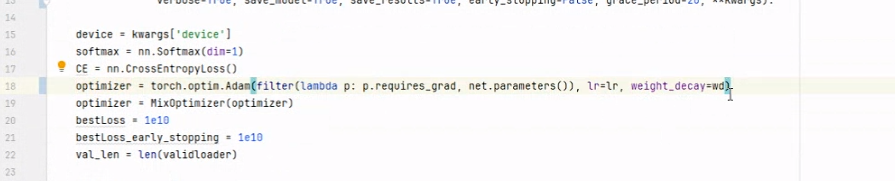

# UNIDA Run

In [ ]:
!pip install diptest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.7/195.7 kB 12.9 MB/s eta 0:00:00


In [ ]:
# remove old logs
!rm -rf experiments_logs

In [ ]:
!python main_uni.py --experiment_description WISDM --dataset WISDM --num_runs 5

Streaming output truncated to the last 5000 lines.
best f1: 0.47205387205387206
[Epoch : 25/50]
best f1: 0.48033225684443276
[Epoch : 27/50]
best f1: 0.5082934609250399
[Epoch : 40/50]
best f1: 0.5532495256166983
===== Correct ====
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, array([0.11599505])]
Dataset: WISDM
Method:  RAINCOAT
Source: 16 ---> Target: 4
Run ID: 1
[Epoch : 1/50]
best f1: 0.20472120472120472
[Epoch : 2/50]
best f1: 0.2534154844499672
[Epoch : 3/50]
best f1: 0.30009620009620014
[Epoch : 4/50]
best f1: 0.4028138528138528
[Epoch : 5/50]
best f1: 0.4411645364171231
[Epoch : 6/50]
best f1: 0.47614496216646757
[Epoch : 7/50]
best f1: 0.48282828282828283
[Epoch : 10/50]
best f1: 0.49968645677714446
[Epoch : 11/50]
best f1: 0.520230607966457
[Epoch : 12/50]
best f1: 0.5271392081736909
[Epoch : 13/50]
best f1: 0.5453805453805454
[Epoch : 18/50]
best f1: 0.5563492063492064
[Epoch : 19/50]
best f1: 0.5640223747775235
===== Correct ====
[10000000000.0

In [ ]:
import pandas as pd

file_path = '/content/SRP_Domain_Adaptation/experiments_logs/WISDM-RAINCOAT-uni/WISDM-RAINCOAT-uni/average_correct.csv'

df = pd.read_csv(file_path)

#print(df)

# print last row (avg)
print(df.tail(1))
